# Reading Single Day of Data

Getting things set up

In [1]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib as mpl
from bokeh import palettes
from bokeh.charts import Bar
import math
from IPython.display import Image

In [2]:
from bokeh.io import output_notebook, show
output_notebook()

Loading BokehJS ...

In [3]:
%matplotlib inline

The below file is a sample day of data stored as an HDF5 file. It can be read as a DataFrame.

In [16]:
file = r'D:\ADSB\working\h5\2016-12-02.h5'

In [17]:
store = pd.HDFStore(file)

In [18]:
store

<class 'pandas.io.pytables.HDFStore'>
File path: D:\ADSB\working\h5\2016-12-02.h5
/data            frame_table  (typ->appendable,nrows->5129914,ncols->60,indexers->[index],dc->[Alt,Cou,FSeen,PosTime,From,Icao,Id,Lat,Long,Mil,To,Type,Op,OpIcao,Help,Stops])

How many rows are in the file?

In [19]:
store.get_storer('data').nrows

5129914

In [21]:
day_of_data_df = store['data']

And how many unique aircraft reports?

In [23]:
len(day_of_data_df['Icao'].unique())

105885

And how many of the rows contain lat/long/alt?

In [24]:
day_of_data_df['Lat'].count(), day_of_data_df['Long'].count(), day_of_data_df['Alt'].count()

(4349182, 4349182, 5020477)

What about Manufacturer or Aircraft Type?

In [25]:
day_of_data_df['Man'].count(),day_of_data_df['Type'].count()

(4814090, 4813125)

Below is a Pivot Table showing the number of unique aircraft and the number of unique aircraft manufacturers by Airaft Country (where it is registered).

In [26]:
pd.pivot_table(day_of_data_df,values=['Id','Man'],index='Cou', 
               aggfunc=lambda x: len(x.unique())).sort_values(by='Id',ascending=False)[:30]

,Id,Man
Cou,,
Unknown or unassigned country,28154,10
United States,20182,274
United Kingdom,6227,275
Germany,5460,121
China,3406,16
France,2905,97
Russia,2657,18
Spain,2476,36
Canada,2325,112


## Airfraft Manufacturers 

In [27]:
aircraft_df = day_of_data_df[['Id','Cou','Year','Man','Type']].dropna(how='all')
aircraft_df = aircraft_df.drop_duplicates(subset='Id')

Here are the top aircraft manufacturers.

In [28]:
mfr = aircraft_df.groupby('Man').count()['Id'].sort_values(ascending=False)[:10]
aircraft_df_by_mfr = aircraft_df[aircraft_df['Man'].isin(list(mfr.index))].groupby(['Man']).count()
aircraft_df_by_mfr = aircraft_df_by_mfr.sort_values(by='Id', ascending=False)
print('Total number of manufactuers: %i' % len(aircraft_df.groupby('Man').count()['Id']))
aircraft_df_by_mfr['Id']

Total number of manufactuers: 593


Man
Boeing                       8954
Airbus                       7137
Cessna                       3597
Bombardier                   2403
Embraer                      1625
Piper                        1565
Beech                         938
Eurocopter                    716
Raytheon Aircraft Company     591
Gulfstream Aerospace          533
Name: Id, dtype: int64

In [29]:
p = Bar(aircraft_df_by_mfr, label='index', values='Id', 
        xlabel='Aircraft Manufacturer', ylabel='Number of Aircraft',
        title="Major Aircraft Manufactures", width=800, legend=None, 
        tools='pan,wheel_zoom,box_zoom,reset',color='wheat')
p.title.text_font_size = "12pt"
p.xaxis.axis_label_text_font_size = "12pt"
p.yaxis.axis_label_text_font_size = "12pt"
p.xaxis.major_label_text_font = "10pt"
p.yaxis.major_label_text_font = "10pt"
show(p)

## Airports by Country

Grabed a csv that provides airports (by ICAO name) to county.

In [30]:
airport_codes = pd.read_csv('https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat', 
                            index_col=0,header=None)
airport_codes.columns = ['Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude', 
                                     'Longitude', 'Altitude', 'Timezone', 'DST', 'Tz', 'Type', 'Source']
airport_codes.set_index('ICAO',drop=True,inplace=True)
airport_codes.head(3)

,Name,City,Country,IATA,Latitude,Longitude,Altitude,Timezone,DST,Tz,Type,Source
ICAO,,,,,,,,,,,,
AYGA,Goroka Airport,Goroka,Papua New Guinea,GKA,-6.08169,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
AYMD,Madang Airport,Madang,Papua New Guinea,MAG,-5.20708,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
AYMH,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,-5.82679,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports


Construct a dataframe listing the number (and percentage) of each arrival/departure.

In [31]:
def country_lu(s):
    if s in airport_codes.index: 
        return airport_codes.loc[airport_codes.index == s, 'Country'].item()
    else:
        return ''

def city_lu(s):
    if s in airport_codes.index: 
        return airport_codes.loc[airport_codes.index == s, 'City'].item()
    else:
        return ''

In [36]:
us_airports = airport_codes[airport_codes['Country'] == 'United States'].index.values
usa_from = day_of_data_df[day_of_data_df['From'].isin(us_airports)]
usa_to = day_of_data_df[day_of_data_df['To'].isin(us_airports)]
us_airports_df = pd.concat((usa_from, usa_to)).drop_duplicates()

In [37]:
airports = pd.DataFrame()
airports['From'] = day_of_data_df.groupby(["To"]).Id.nunique().sort_values(ascending=False).sort_values(ascending=True)
airports['To'] = day_of_data_df.groupby(["From"]).Id.nunique().sort_values(ascending=False).sort_values(ascending=True)
airports['From'] = airports['From'].fillna(0).map(np.int64)
airports['To'] = airports['To'].fillna(0).map(np.int64)
airports['From (%)'] = airports['From']/airports['From'].sum() * 100
airports['To (%)'] = airports['To']/airports['To'].sum() * 100
airports['From'] = airports['From'].fillna(0)
airports.sort_values(by='To',ascending=False).head(20)

,From,To,From (%),To (%)
To,,,,
EGLL,582,525,2.018240,1.842364
KLAX,532,499,1.844852,1.751123
EDDF,410,411,1.421785,1.442308
ZBAA,429,394,1.487672,1.382650
LFPG,379,380,1.314284,1.333520
EHAM,380,376,1.317751,1.319483
KJFK,356,370,1.234525,1.298428
ZSPD,370,369,1.283074,1.294919
VHHH,346,336,1.199847,1.179113


And here it is grouped by country.

In [542]:
airport_country = airports.groupby(airports['Country'])
airport_country.sum().sort_values(by='From',ascending=False).head(20)

,From,To,From (%),To (%)
Country,,,,
United States,1378,1125,43.871379,44.501582
United Kingdom,279,275,8.882521,10.878165
China,224,225,7.131487,8.900316
Germany,203,204,6.462910,8.069620
Netherlands,122,135,3.884113,5.340190
Russia,117,72,3.724928,2.848101
Hong Kong,104,83,3.311047,3.283228
France,99,142,3.151862,5.617089
Turkey,93,89,2.960840,3.520570


Below is a plot of the top 30 international departure airports.

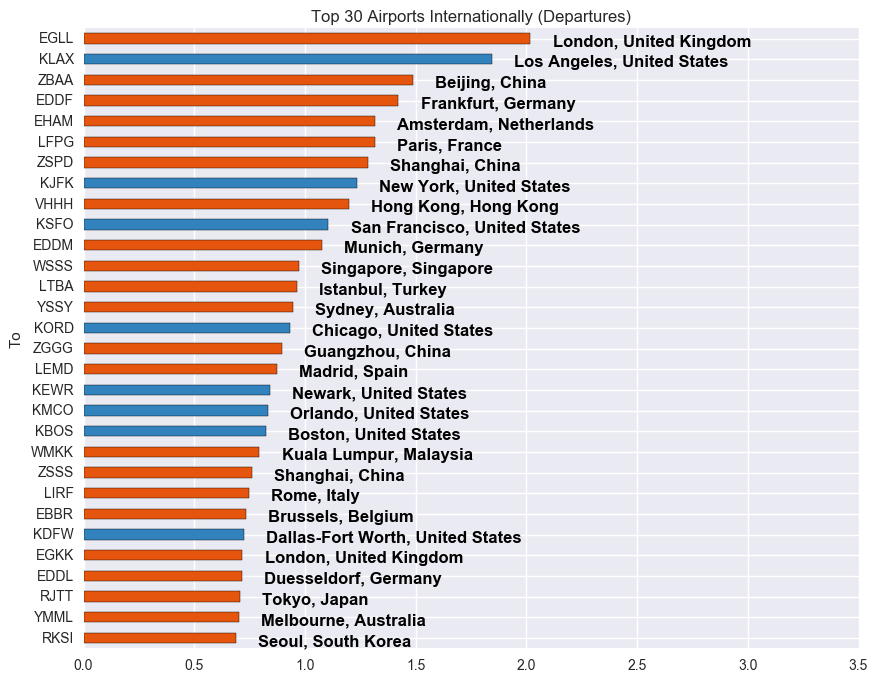

In [47]:
mpl.rcParams['figure.figsize'] = 10, 8
mpl.rcParams['figure.dpi'] = 100
d = airports.sort_values(by='From',ascending=False)[:30].sort_values(by='From',ascending=True)
color = np.where(d.index.isin(us_airports),palettes.d3['Category20c'][5][0],palettes.d3['Category20c'][5][-1])
ax = d['From (%)'].plot(kind='barh',color=color, title='Top 30 Airports Internationally (Departures)')
city = [city_lu(code) for code in d.index.values]
country = [country_lu(code) for code in d.index.values]
city_countr = [', '.join(s) for s in zip(city,country)] 
ax.set_xbound(upper=3.5)
rects = ax.patches
for rect, label in zip(rects, city_countr):
    width = rect.get_width()
    height = rect.get_height()
    y = rect.get_y()
    ax.text(width + .10,y + height * .95, label, color='black',fontsize=12, ha='left', va='top', weight='heavy')


Below is a plot of the top 30 international arrival airports.

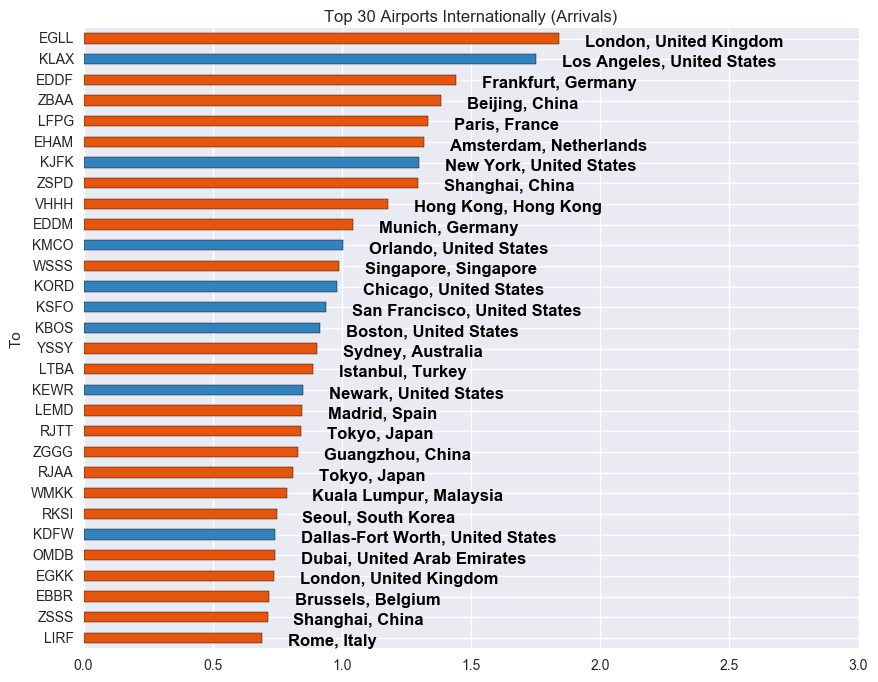

In [50]:
mpl.rcParams['figure.figsize'] = 10, 8
mpl.rcParams['figure.dpi'] = 100
d = airports.sort_values(by='To',ascending=False)[:30].sort_values(by='To',ascending=True)
color = np.where(d.index.isin(us_airports),palettes.d3['Category20c'][5][0],palettes.d3['Category20c'][5][-1])
ax = d['To (%)'].plot(kind='barh', color=color, title='Top 30 Airports Internationally (Arrivals)')
city = [city_lu(code) for code in d.index.values]
country = [country_lu(code) for code in d.index.values]
city_countr = [', '.join(s) for s in zip(city,country)] 
ax.set_xbound(upper=3)
rects = ax.patches
for rect, label in zip(rects, city_countr):
    width = rect.get_width()
    height = rect.get_height()
    y = rect.get_y()
    ax.text(width + .1,y + height * .95, label, color='black',fontsize=12, ha='left', va='top', weight='heavy')

# Here is similar data for flights that start or stop in the US

In [51]:
usa_airports = pd.DataFrame()
usa_airports['From'] = day_of_data_df.groupby(["From"]).Id.nunique()
usa_airports['To'] = day_of_data_df.groupby(["To"]).Id.nunique()
usa_airports['From'] = usa_airports['From'].fillna(0).map(np.int64)
usa_airports['To'] = usa_airports['To'].fillna(0).map(np.int64)
usa_airports['From (%)'] = usa_airports['From']/usa_airports['From'].sum() * 100
usa_airports['To (%)'] = usa_airports['To']/usa_airports['To'].sum() * 100
usa_airports['Country'] = [country_lu(code) for code in usa_airports.index.values]
usa_airports['Domestic'] = usa_airports.index.isin(us_airports)
usa_airports.index.name = 'Airport'
usa_airports.sort_values(by='To',ascending=False).head(5)

,From,To,From (%),To (%),Country,Domestic
Airport,,,,,,
EGLL,525,582,1.828759,2.034823,United Kingdom,False
KLAX,499,532,1.738191,1.860010,United States,True
ZBAA,394,429,1.372440,1.499895,China,False
EDDF,411,410,1.431657,1.433466,Germany,False
EHAM,376,380,1.309739,1.328578,Netherlands,False


In [52]:
usa_airports.groupby(usa_airports['Domestic']).sum()

,From,To,From (%),To (%)
Domestic,,,,
False,22508,22426,78.403233,78.407104
True,6200,6176,21.596767,21.592896


The top 30 airports where the destination is in the US.

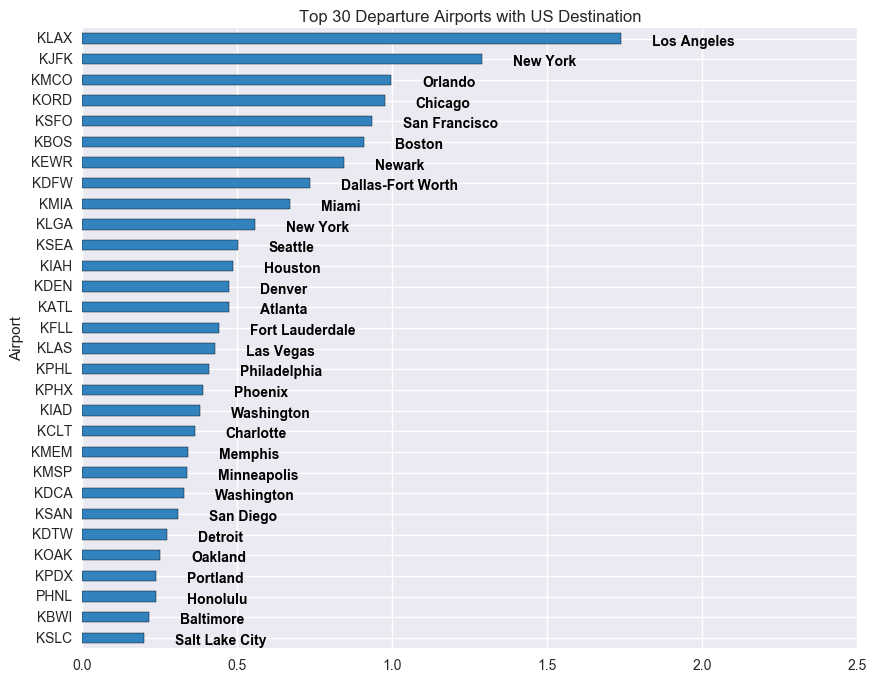

In [54]:
mpl.rcParams['figure.figsize'] = 10, 8
mpl.rcParams['figure.dpi'] = 100
d = usa_airports[usa_airports.To.index.isin(us_airports)].sort_values(by='From',ascending=False)[:30].sort_values(by='From',ascending=True)
color = np.where(d.index.isin(us_airports),
                 palettes.d3['Category20c'][5][0],palettes.d3['Category20c'][5][-1])
ax = d['From (%)'].plot(kind='barh', color=color, title='Top 30 Departure Airports with US Destination')
city = [city_lu(code) for code in d.index.values]
country = [country_lu(code) for code in d.index.values]
ax.set_xbound(upper=2.5)
rects = ax.patches
for rect, label in zip(rects, city):
    width = rect.get_width()
    height = rect.get_height()
    y = rect.get_y()
    ax.text(width + .1,y + height * .95, label, color='black',fontsize=10, ha='left', va='top', weight='heavy')

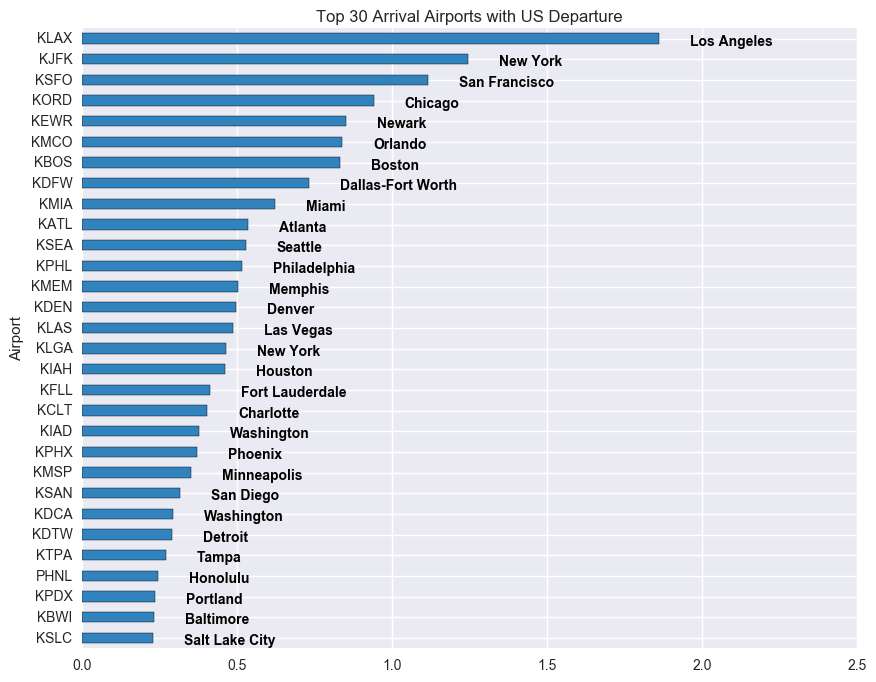

In [56]:
mpl.rcParams['figure.figsize'] = 10, 8
mpl.rcParams['figure.dpi'] = 100
d = usa_airports[usa_airports.From.index.isin(us_airports)].sort_values(by='To',ascending=False)[:30].sort_values(by='To',ascending=True)
color = np.where(d.index.isin(us_airports), palettes.d3['Category20c'][5][0],palettes.d3['Category20c'][5][-1])
ax = d['To (%)'].plot(kind='barh',  color=color, title='Top 30 Arrival Airports with US Departure')
city = [city_lu(code) for code in d.index.values]
country = [country_lu(code) for code in d.index.values]
ax.set_xbound(upper=2.5)
rects = ax.patches
for rect, label in zip(rects, city):
    width = rect.get_width()
    height = rect.get_height()
    y = rect.get_y()
    ax.text(width + .1,y + height * .95, label, color='black',fontsize=10, ha='left', va='top', weight='heavy')

In [57]:
international = usa_airports[~usa_airports.From.index.isin(us_airports)]
international = international[~international.To.index.isin(us_airports)]
international.sort_values(by='From',ascending=False).head(10)

,From,To,From (%),To (%),Country,Domestic
Airport,,,,,,
EGLL,525,582,1.828759,2.034823,United Kingdom,False
EDDF,411,410,1.431657,1.433466,Germany,False
ZBAA,394,429,1.372440,1.499895,China,False
LFPG,380,379,1.323673,1.325082,France,False
EHAM,376,380,1.309739,1.328578,Netherlands,False
ZSPD,369,370,1.285356,1.293616,China,False
VHHH,336,346,1.170405,1.209706,Hong Kong,False
EDDM,297,311,1.034555,1.087337,Germany,False
WSSS,282,280,0.982305,0.978953,Singapore,False


In [58]:
international_country = international.groupby(international['Country'])
print('Main contries traveled to:\n',', '.join(list(international_country.sum().sort_values(by='To',
                                                                                 ascending=False).head(20).index)))
print('Main countries traveled from:\n', ', '.join(list(international_country.sum().sort_values(by='From',
                                                                                   ascending=False).head(20).index)))

Main contries traveled to:
 China, United Kingdom, Germany, Australia, Spain, Japan, France, Italy, Brazil, Russia, Canada, Mexico, Turkey, Netherlands, Malaysia, Hong Kong, Indonesia, Sweden, Switzerland, Norway
Main countries traveled from:
 China, United Kingdom, Germany, Australia, Japan, Spain, France, Brazil, Italy, Russia, Canada, Turkey, Malaysia, Netherlands, Mexico, Indonesia, Hong Kong, Sweden, Norway, United Arab Emirates


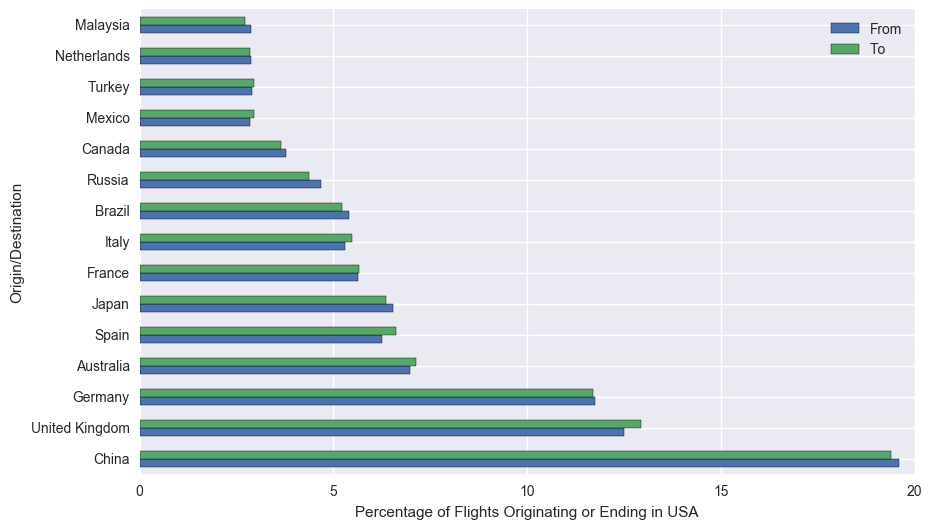

In [62]:
mpl.rcParams['figure.figsize'] = 10, 6
mpl.rcParams['figure.dpi'] = 100
from_ = international_country.sum().sort_values(by='From',ascending=False).head(15)['From']
from_ = from_ / from_.sum() * 100
to_ = international_country.sum().sort_values(by='To',ascending=False).head(15)['To']
to_ = to_ / to_.sum() * 100
ax = pd.concat([from_, to_], axis=1).sort_values(by='To',ascending=False).plot(kind='barh')
ax.set_xlabel('Percentage of Flights Originating or Ending in USA')
ax.set_ylabel('Origin/Destination')

And Atlanta...

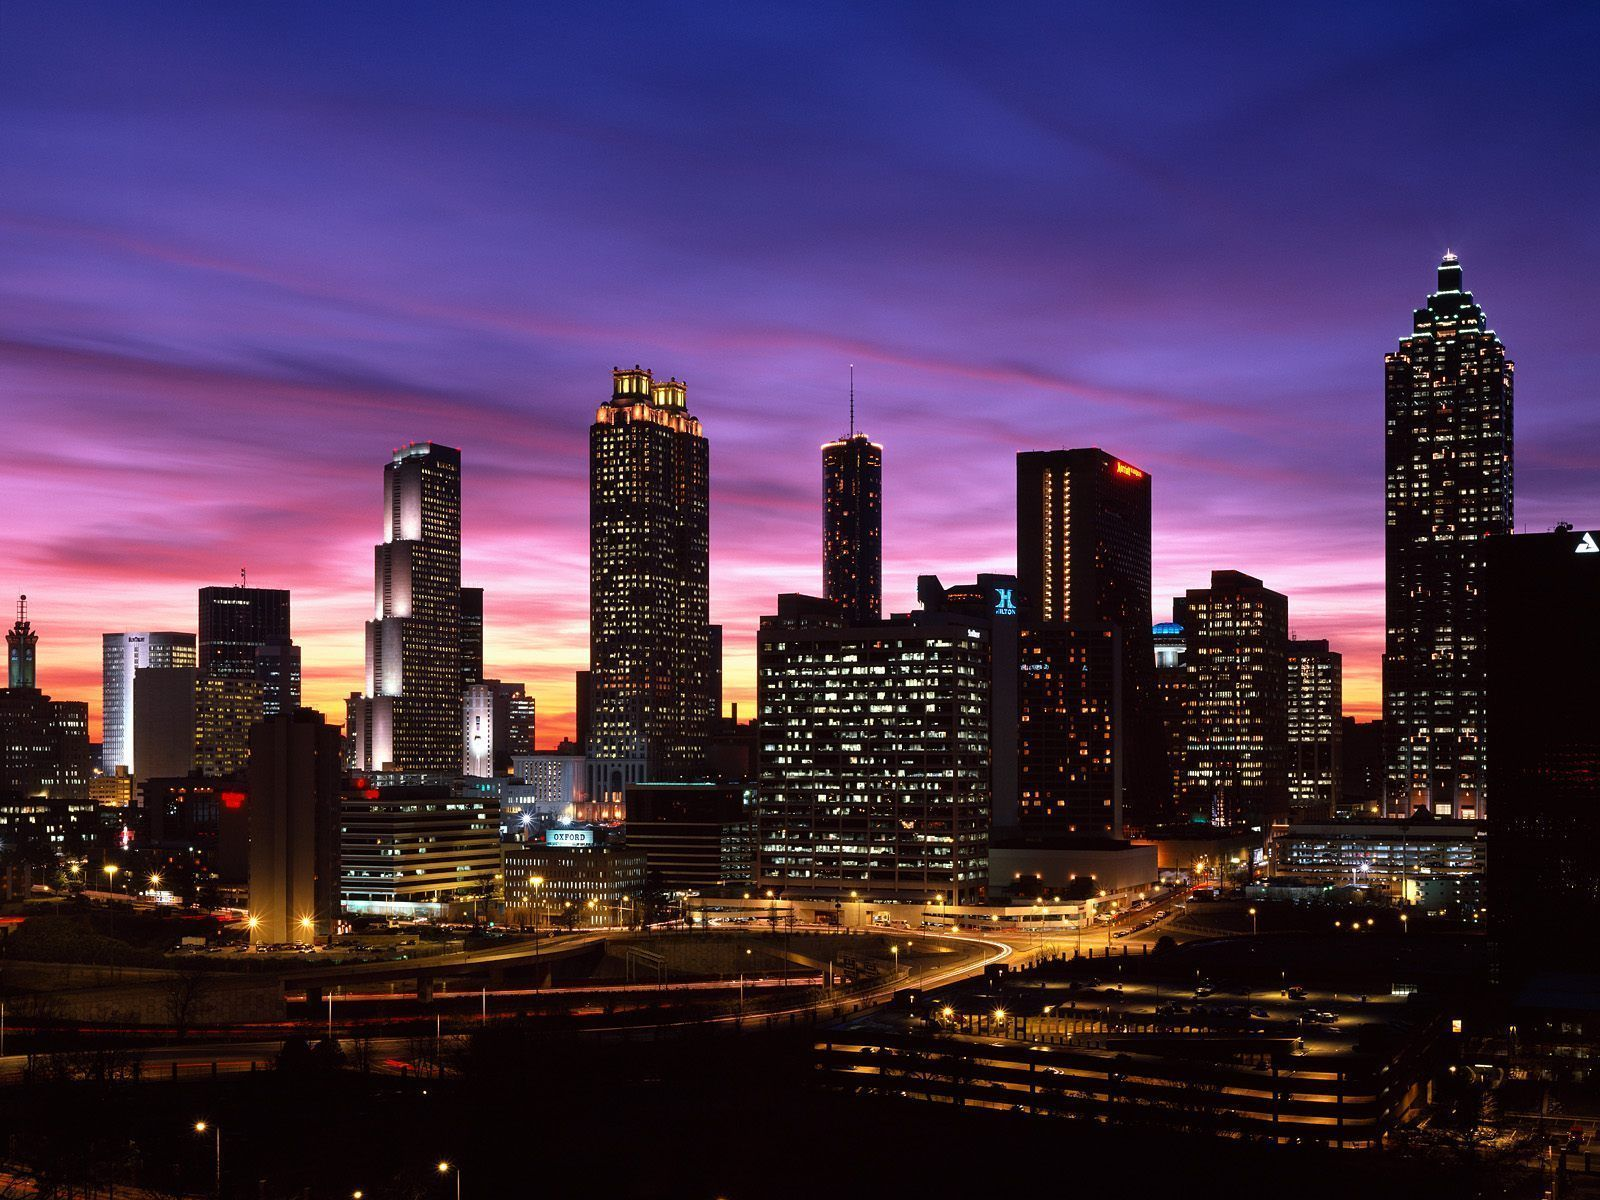

In [288]:
Image("http://wallpapercave.com/wp/E48LtWF.jpg")

In [65]:
atl_ = store.select('data',where='From = "KATL" | To = "KATL"').drop_duplicates()
atl = pd.DataFrame()
atl['From'] = atl_.groupby(["To"]).Id.nunique().sort_values(ascending=False).sort_values(ascending=True)
atl['To'] = atl_.groupby(["From"]).Id.nunique().sort_values(ascending=False).sort_values(ascending=True)
atl['From'] = atl['From'].fillna(0).map(np.int64)
atl['To'] = atl['To'].fillna(0).map(np.int64)
atl['From (%)'] = atl['From']/atl['From'].sum() * 100
atl['To (%)'] = atl['To']/atl['To'].sum() * 100
atl['Country'] = [country_lu(code) for code in atl.index.values]
atl.drop('KATL', inplace=True)
atl.sort_values(by='To',ascending=False).head(20)

,From,To,From (%),To (%),Country
To,,,,,
KLAX,11,9,3.942652,3.913043,United States
KSFO,5,8,1.792115,3.478261,United States
KMCO,1,6,0.358423,2.608696,United States
LFPG,2,6,0.716846,2.608696,France
KLGA,4,5,1.433692,2.173913,United States
KORD,2,5,0.716846,2.173913,United States
KJFK,2,5,0.716846,2.173913,United States
EHAM,2,5,0.716846,2.173913,Netherlands
EGLL,2,4,0.716846,1.739130,United Kingdom
